In [43]:
import csv
from urllib.error import HTTPError, URLError
from urllib.request import urlopen
import pickle 
import pandas as pd
import numpy as np
import datetime

from bs4 import BeautifulSoup
from nltk import tokenize

from utils import pickle_load, pickle_dump 


In [36]:
base = "https://www.mountainproject.com/forum/103989406/womens-forum"
ext = "?page="
num_pages = 12
forum_post_urls = []

for i in range(1, num_pages + 1):
    page = urlopen(base+ext+str(i)).read()
    soup = BeautifulSoup(page)
    forum_post_urls.extend([i.td.a.get('href') for i in soup.find_all('tr')[1:]])


In [52]:
pickle_dump(forum_post_urls, 'womens-post-urls')

In [128]:
forum_post_urls = pickle_load('womens-post-urls')

In [ ]:

df = []
for thread_url in forum_post_urls:
    page = urlopen(thread_url).read()
    soup = BeautifulSoup(page)
    messages = soup.find_all('tr')

    for message in messages:
        bio = message.find('div', class_='bio text-truncate')
        info = [i.strip() for i in bio.find('span', class_='text-warm small').text.replace('\t', '').replace('\n', '').split('·')[1:]]

        post_id = thread_url.split('/')[-2]
        date = info[0] # TODO: convert this from '2 Days Ago'
        username = bio.find('strong').text
        body = message.find('div', class_='fr-view').text
        try:
            num_likes = message.find('span', class_='num-likes').text.replace('\n', '').strip()
        except:
            num_likes = 'post removed'
        location = info[1]
        joined = info[2][7:]
        points = info[3]


        column = [post_id, date, username, body, num_likes, location, joined, points]
        df.append(column)


import datetime
def subtract_days_from_current(x):
    # Get current date
    current_date = datetime.date.today()
    
    # Subtract x days
    new_date = current_date - datetime.timedelta(days=x)
    
    # Format the date
    formatted_date = new_date.strftime("%b %d, %Y")
    
    return formatted_date


columns = ['post_id', 'date', 'username', 'body', 'num_likes', 'location', 'joined', 'points']
df = pd.DataFrame(df, columns=columns)
df.loc[:, 'body'] = df.body.apply(lambda x: x.replace('\n', ''))
df.date[['days' in i for i in df.date.values]] = pd.to_numeric(df.date[['days' in i for i in df.date.values]].str[0]).apply(subtract_days_from_current)
df['mean_word_length'] = df.body.map(lambda rev: np.mean([len(word) for word in rev.split()]))

df.to_csv('data/womens-forum.csv', index=False)


In [3]:
df = pd.read_csv('data/womens-forum.csv')

## Exploratory Data Analysis

### Data cleaning

In [11]:
df.head()

,post_id,date,username,body,num_likes,location,joined,points,mean_word_length
0,114076020,"Feb 9, 2018",Nick Wilder,This is a place for women to share experiences...,77,"Boulder, CO",Jan 2005,"Points: 4,103",4.971831
1,124962198,"Sep 18, 2023",Zoe Stone,I’m going to be driving from the northeast to ...,2,"Narvik, NO",Sep 2016,Points: 0,4.116959
2,124962198,"Sep 27, 2023",Jenny Beck,Let me know if you’re coming through Moab!,1,West Penn,Oct 2020,Points: 0,4.375000
3,125010698,"Sep 27, 2023",Jenny Beck,Hey there! I would love to find some women cli...,1,West Penn,Oct 2020,Points: 0,4.327869
4,125008673,"Sep 26, 2023",Stephanie Robertson,I’ll be in Sedona area this weekend and would ...,0,Albuquerque,Jun 2023,Points: 0,4.488889


In [44]:
df.date[df.date.str.contains('hours')] = [datetime.date.today().strftime("%b %d, %Y") for _ in df.date[df.date.str.contains('hours')]]

/tmp/ipykernel_4483/3656947867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date[df.date.str.contains('hours')] = [datetime.date.today().strftime("%b %d, %Y") for _ in df.date[df.date.str.contains('hours')]]


In [37]:
# drop the "post removed" posts
df.drop(df[df.num_likes.str.contains('post removed')].index, inplace=True)

In [69]:
df['points'] = df['points'].str[-1].astype(int)
df.num_likes = df.num_likes.astype(int)

In [15]:
df['mean_sent_length'] = df.body.map(lambda text: np.mean([len(sent) for sent in tokenize.sent_tokenize(text)]))

/home/tybens/Desktop/Senior/NLP IW/climbing-analysis/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tybens/Desktop/Senior/NLP IW/climbing-analysis/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
df['word_count'] = df.body.map(lambda text: len(text.split(' ')))

### Distribution Statistics

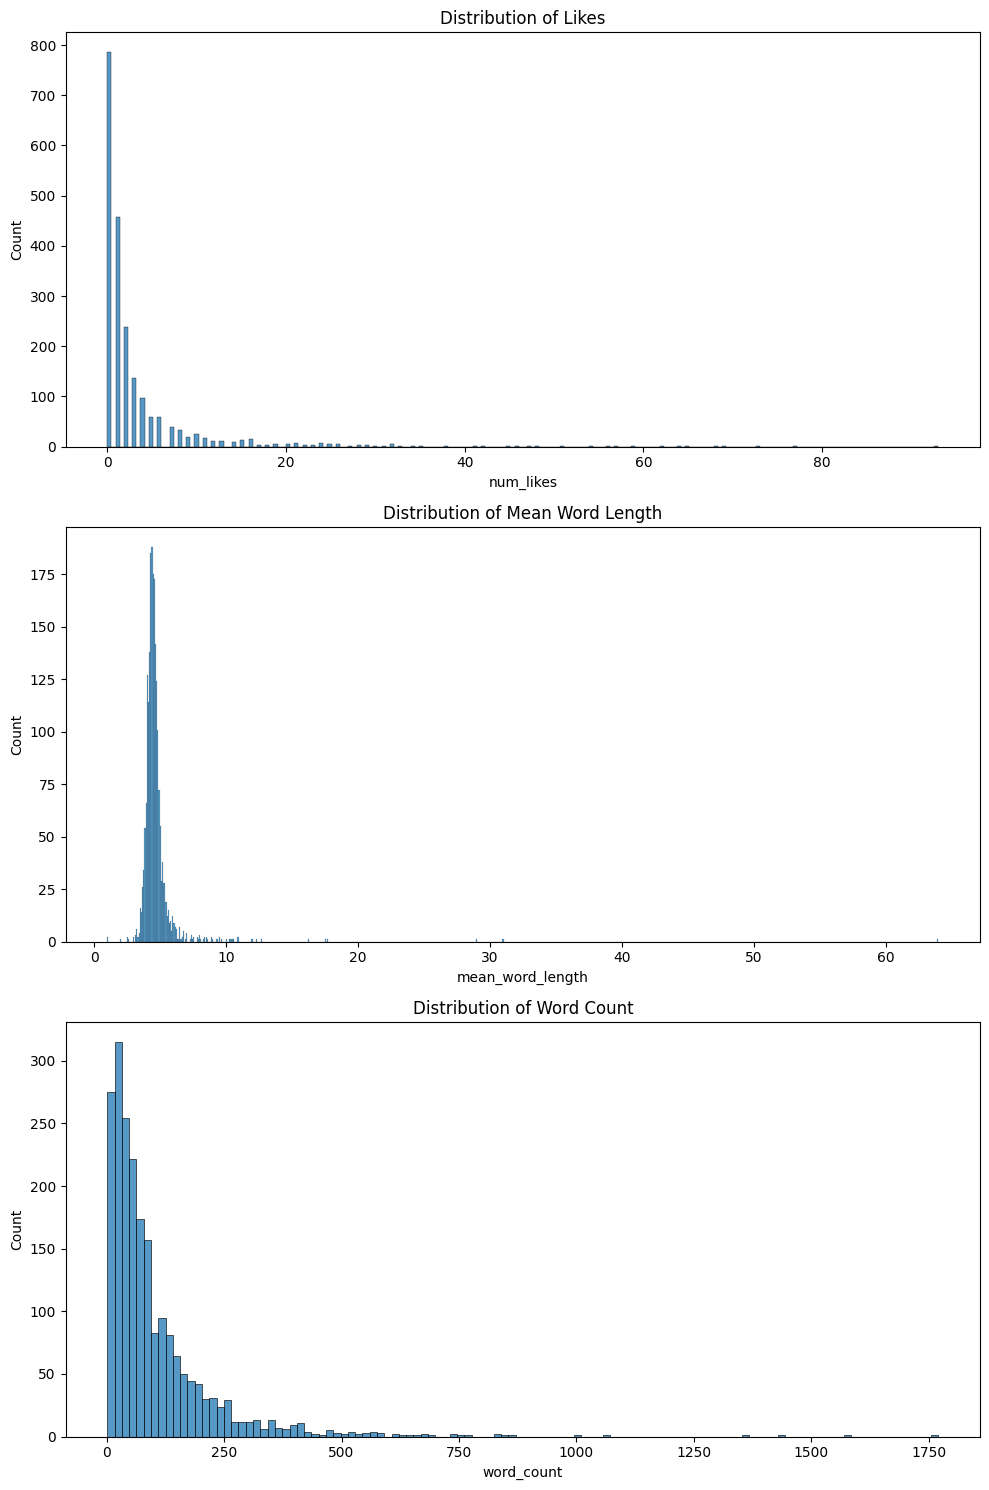

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure with 3 subplots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Distribution of likes
sns.histplot(df['num_likes'].astype(int), ax=ax[0])
ax[0].set_title('Distribution of Likes')

# Distribution of mean_word_length
sns.histplot(df['mean_word_length'], ax=ax[1])
ax[1].set_title('Distribution of Mean Word Length')

# Distribution of word_count
sns.histplot(df['word_count'], ax=ax[2])
ax[2].set_title('Distribution of Word Count')

# Adjust layout
plt.tight_layout()
plt.show()

In [55]:
df.date = pd.to_datetime(df.date)

In [70]:
df.groupby(df['date'].dt.to_period("M"))['num_likes'].sum()

date
2015-03      7
2017-03      8
2017-08      1
2018-02    247
2018-03    305
          ... 
2023-05     46
2023-06     48
2023-07     16
2023-08     15
2023-09     30
Freq: M, Name: num_likes, Length: 70, dtype: int64

### Time Series

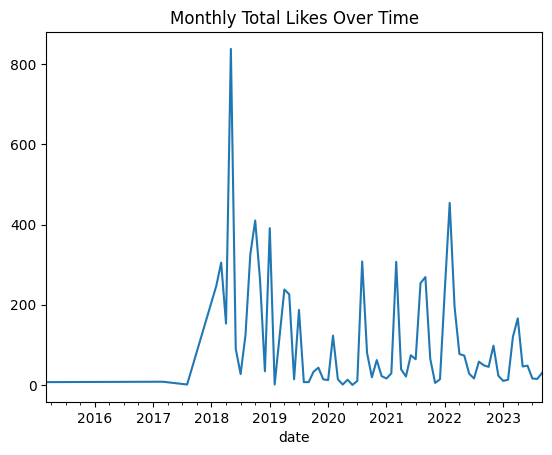

In [72]:
monthly_likes = df.groupby(df['date'].dt.to_period("M"))['num_likes'].sum()

monthly_likes.plot()
plt.title('Monthly Total Likes Over Time')
plt.show()

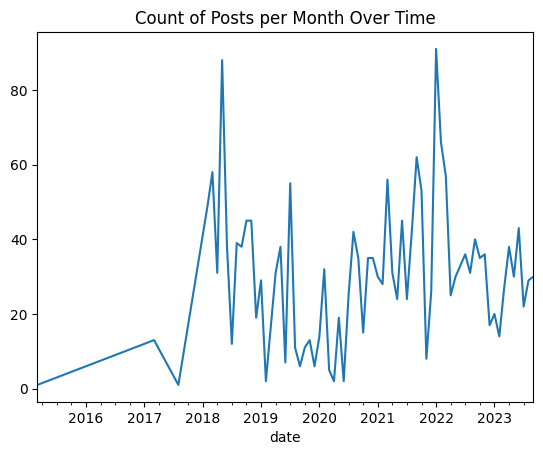

In [74]:
monthly_posts = df.groupby(df['date'].dt.to_period("M")).size()
monthly_posts.plot()

plt.title('Count of Posts per Month Over Time')
plt.show()

In [82]:
top_locations

Index(['Unknown Hometown', 'OH', 'Boulder, CO', 'Boise, ID', 'Belgrade, MT',
       'Denver, CO', 'Upland', 'Portland, OR', 'Atascadero, CA',
       'Salt Lake City, UT', 'Golden, CO', 'Las Vegas, NV', 'Colorado',
       'Albuquerque, NM', 'Bishop, CA'],
      dtype='object', name='location')

### Categorical Analysis

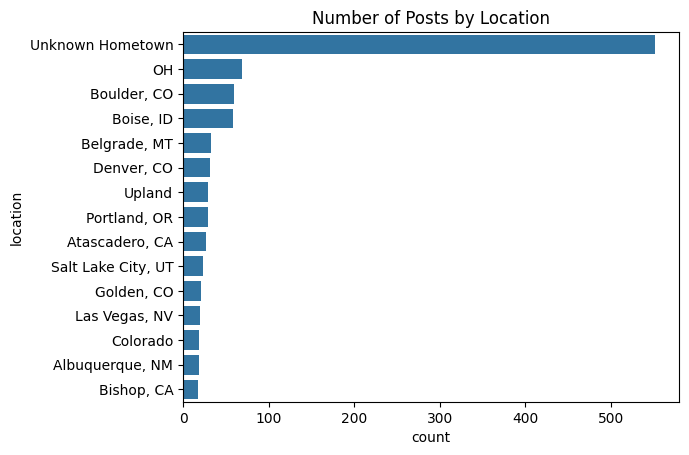

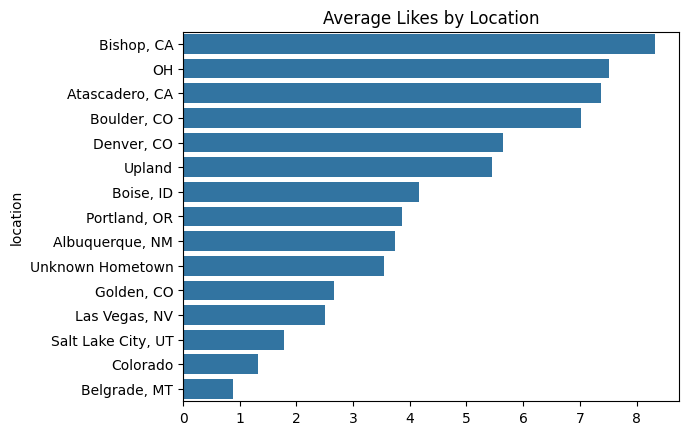

In [99]:
# Number of posts by location
col = 'location'
num = 15


top = df[col].value_counts().index[:num]
sns.countplot(y=df.loc[df.location.isin(top)].location, order=top)
plt.title('Number of Posts by Location')
plt.show()


# Average likes by location
top_locations = df[col].value_counts().head(num).index.tolist()
filtered_data = df[df[col].isin(top_locations)]
avg_likes = filtered_data.groupby(col)['num_likes'].mean()
sns.barplot(y=avg_likes.index, x=avg_likes.values, order=avg_likes.sort_values(ascending=False).index)
plt.title('Average Likes by Location')
plt.show()

### Textual Analysis

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform(df['body'])
top_words = vectorizer.get_feature_names_out()

print("Top 10 words:", top_words)

Top 10 words: ['climb' 'climbing' 'don' 'just' 'know' 'like' 'really' 'time' 've'
 'women']


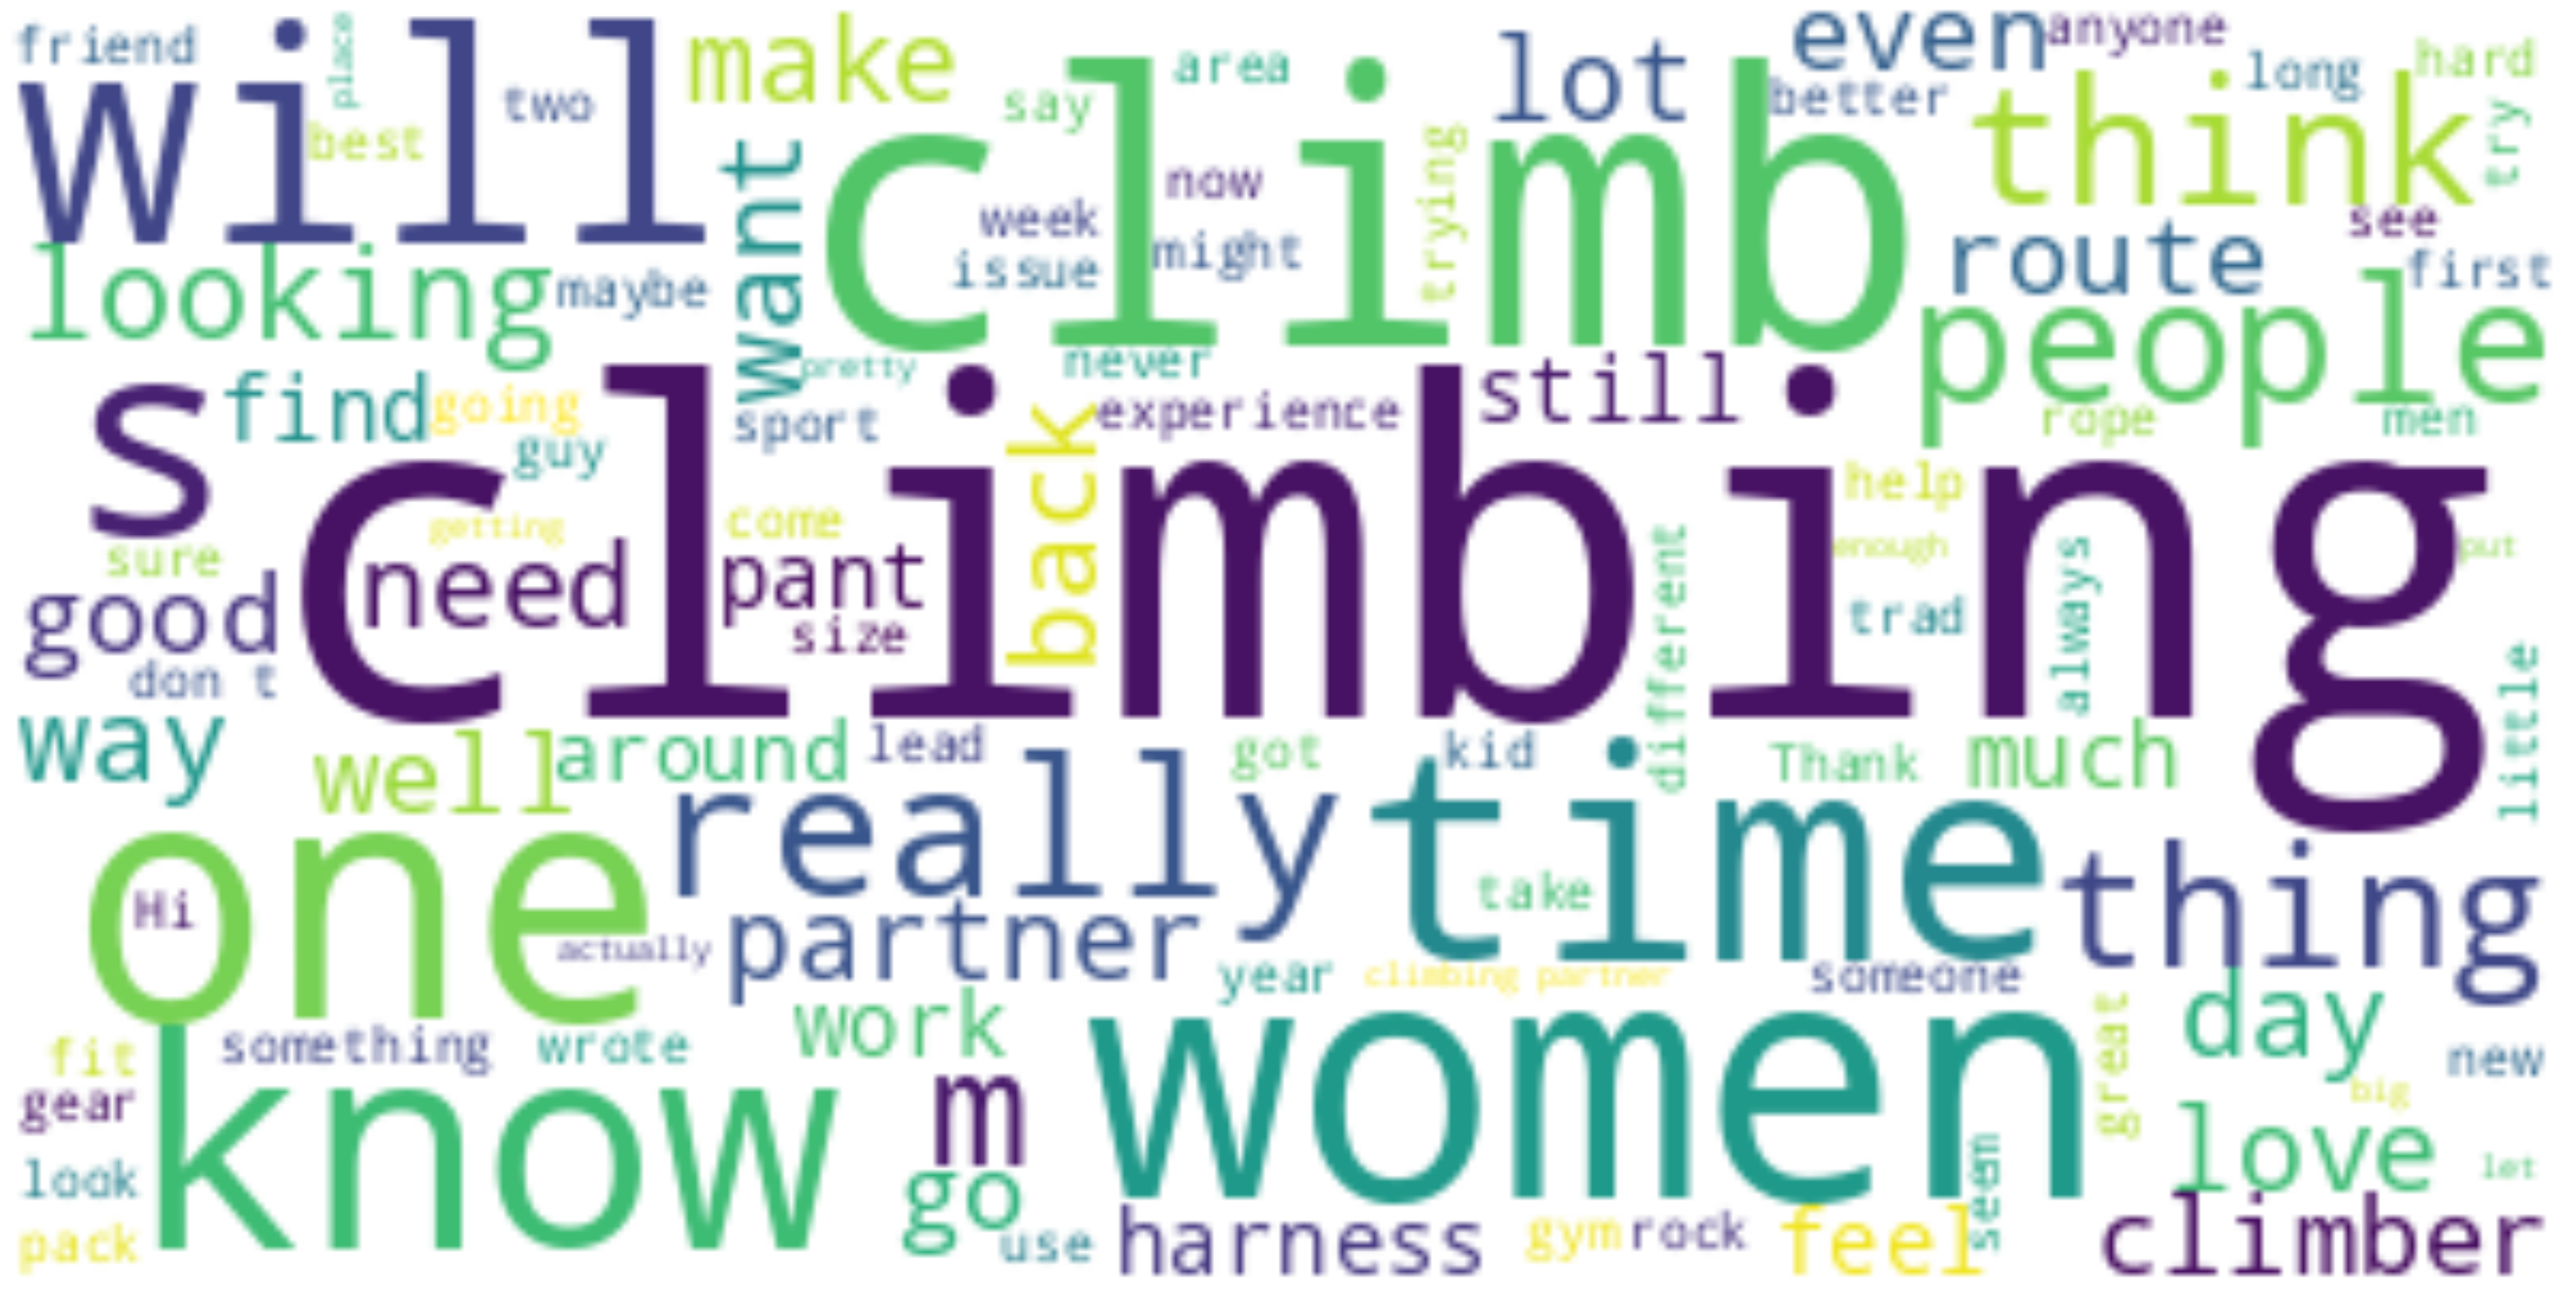

In [150]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from wordcloud import STOPWORDS

additional_stopwords = set(["word1", "word2", "word3"])  # Replace with any other words you deem as stop words
all_stopwords = STOPWORDS.union(additional_stopwords)

wordcloud = WordCloud(stopwords=all_stopwords, max_words=100, background_color="white").generate(" ".join(df['body']))

plt.figure(figsize=(50, 40))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


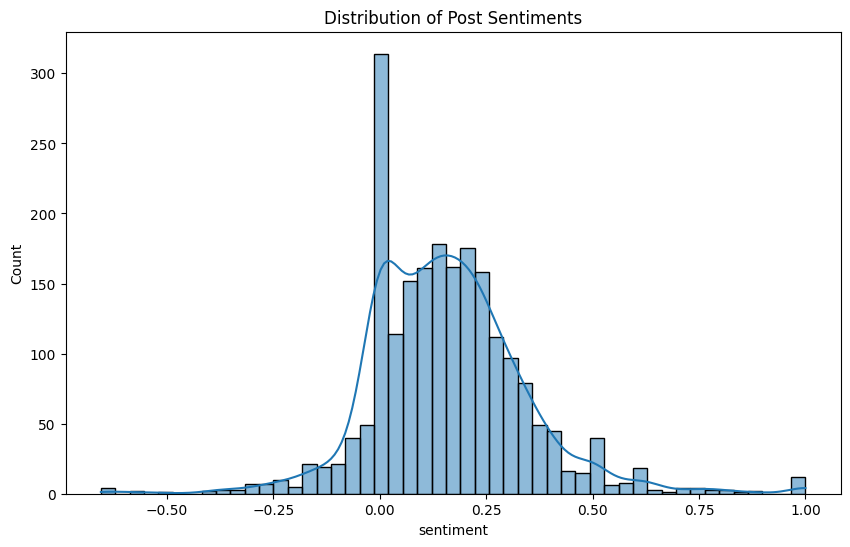

In [108]:
from textblob import TextBlob

df['sentiment'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Distribution of sentiment
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Distribution of Post Sentiments')
plt.show()

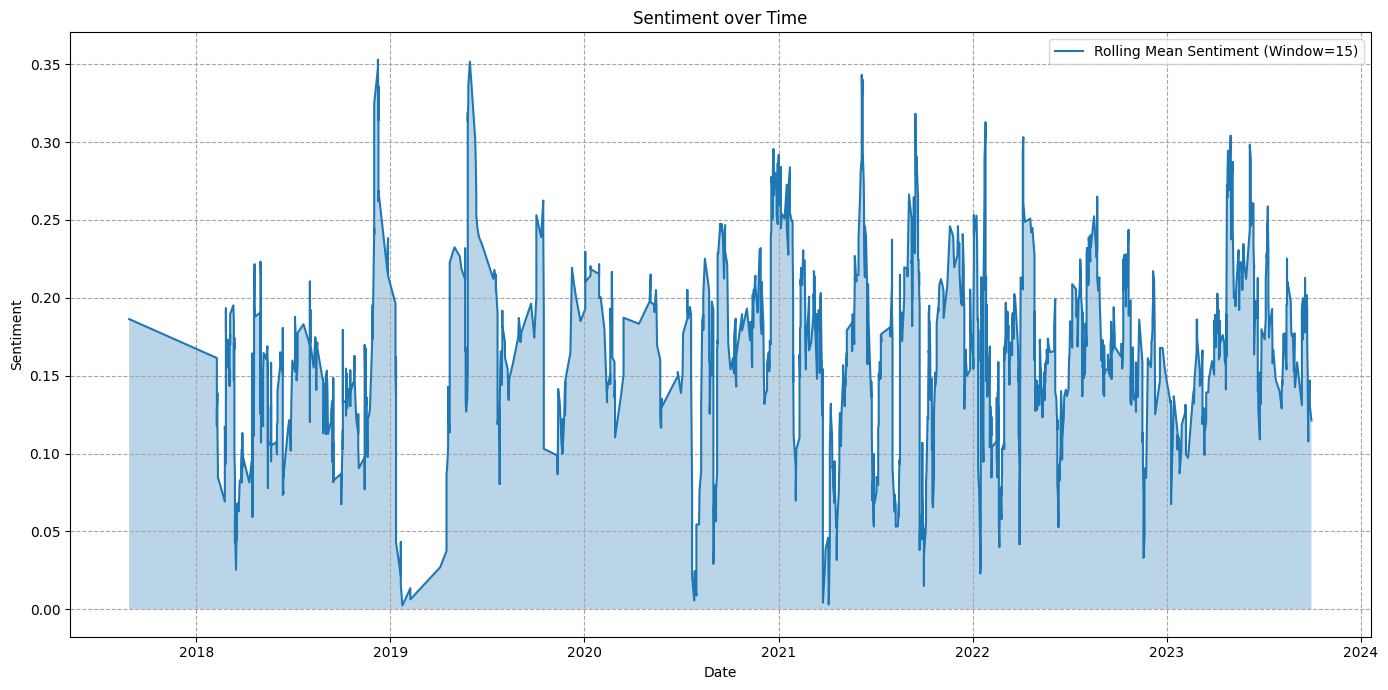

In [142]:
df = df.sort_values(by='date')
window_size = 15

roll = df['sentiment'].rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['date'], roll, label=f'Rolling Mean Sentiment (Window={window_size})')
plt.fill_between(df['date'], roll, alpha=0.3)
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

In [111]:
from sklearn.decomposition import LatentDirichletAllocation

# Using CountVectorizer with more features for LDA
vectorizer_lda = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X_lda = vectorizer_lda.fit_transform(df['body'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)

# Displaying topics
def display_topics(model, feature_names, n_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
        print("\n")

display_topics(lda, vectorizer_lda.get_feature_names_out())

Topic 1:
climbing just like don climb time women think people know


Topic 2:
climbing climb looking love trad sport partners partner area hi


Topic 3:
women climbing wrote just shoes like people cold person forum


Topic 4:
use com https www water surgery using hands good long


Topic 5:
pants harness climbing size like fit gear women ve loops




In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['body'])

lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=42)
lda_tfidf.fit(tfidf)

display_topics(lda_tfidf, tfidf_vectorizer.get_feature_names_out())

Topic 1:
climbing just women don like people think climb time wrote


Topic 2:
looking climbing climb love hi trad sport hey partner area


Topic 3:
com https wrote www forum cold bag helmet la jacket


Topic 4:
sent misty moving available bishop cadillac checking thanks mountain message


Topic 5:
pants harness size fit loops gear like good waist women




### Comparing Sentiment with Topic

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer_lda = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X_lda = vectorizer_lda.fit_transform(df['body'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda.fit_transform(X_lda)


In [125]:
topic_map = ['general', 'partner_search', 'gear_recommendation', 'free_gear', 'sizing_recommendation']

In [126]:
df['dominant_topic'] = [topic_map[i] for i in lda_output.argmax(axis=1)]

In [118]:
df['sentiment'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [127]:
average_sentiments = df.groupby('dominant_topic')['sentiment'].mean()

In [128]:
df.dominant_topic.value_counts()

dominant_topic
general                  671
partner_search           564
sizing_recommendation    431
gear_recommendation      294
free_gear                166
Name: count, dtype: int64

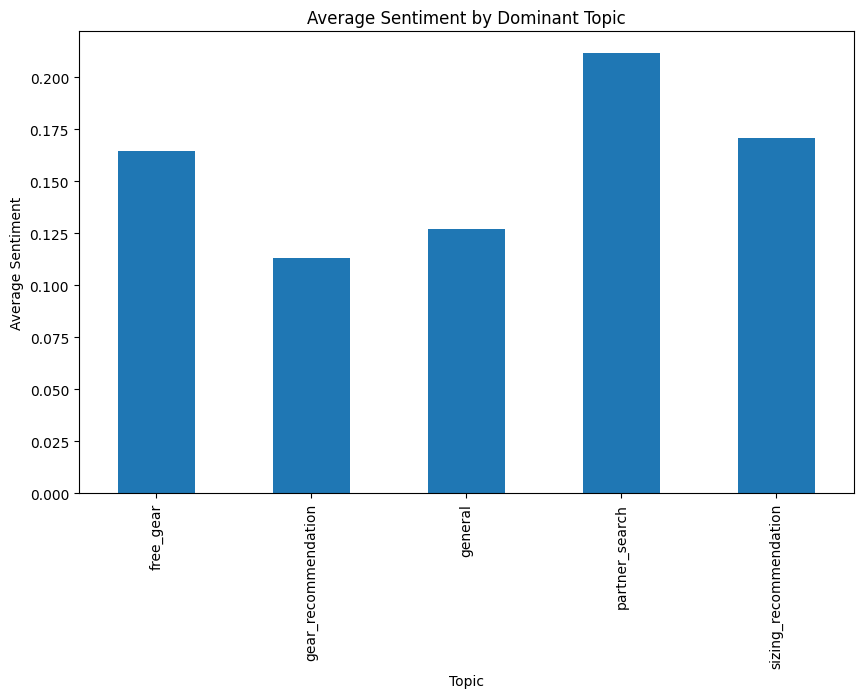

In [129]:
average_sentiments.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment by Dominant Topic')
plt.ylabel('Average Sentiment')
plt.xlabel('Topic')
plt.show()

In [147]:
df.columns

Index(['post_id', 'date', 'username', 'body', 'num_likes', 'location',
       'joined', 'points', 'mean_word_length', 'mean_sent_length',
       'word_count', 'sentiment', 'dominant_topic'],
      dtype='object')